In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [3]:
dataset = pd.read_csv('../../data/pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [4]:
print(dataset.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['pollution']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (43800, 1)
stages_supervised.shape: (43705, 96)


In [7]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
2010-01-05 01:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2010-01-05 02:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
2010-01-05 03:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
2010-01-05 04:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,164.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-30 20:00:00,349.0,327.0,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
2014-12-30 21:00:00,327.0,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,264.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
2014-12-30 22:00:00,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,264.0,221.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0


#### Prior unknown covariates (6)

In [8]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [9]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [10]:
prior_known = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (43800, 10)
prior_known_supervised.shape: (43705, 960)


In [11]:
# prior_known_supervised

### N_out, N_in, K

In [12]:
past_cov = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (43705, 960)


In [13]:
# past_cov_supervised  # 6 + 9 = 15 features

In [14]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [15]:
# past_ws_supervised  # 4

In [16]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [17]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [18]:
# past_cov_ws_supervised

In [19]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var10(t-48),...,shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23),shift_prior_known_supervised_var10(t+23)
0,-7.0,-6.0,1027.0,58.56,4.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-8.0,-6.0,1026.0,61.69,5.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-8.0,-7.0,1026.0,65.71,6.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-8.0,-7.0,1025.0,68.84,7.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-8.0,-7.0,1024.0,72.86,8.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-13.0,3.0,1017.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-13.0,1.0,1017.0,1.78,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-10.0,2.0,1017.0,2.67,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-10.0,-2.0,1017.0,3.12,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], axis=1)


In [21]:
# shift_prior_known_past_cov_ws_supervised

In [22]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
1,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
3,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
4,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,26.0,20.0,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
43701,20.0,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
43702,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,8.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0
43703,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,8.0,8.0,...,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0,8.0


### Concatenation

In [23]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43705, 1536)


### Train & Test set

In [24]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 34964


In [25]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

1512

### Normalization

In [26]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (34964, 1512) (34964, 24) (8741, 1512) (8741, 24)


In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (34964, 72, 21) (34964, 24) (8741, 72, 21) (8741, 24)


### Model

In [40]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)

x1_merge1 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)

x1_merge2 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)

x1_merge3 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge3)

merge = concatenate([model_input, x1])
x = layers.Flatten()(merge)
x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(x)

pm25_pararcnn = Model(model_input, x)
pm25_pararcnn.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 72, 21)]     0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 72, 256)      11008       input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 72, 277)      0           input_5[0][0]                    
                                                                 conv1d_16[0][0]                  
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 72, 128)      71040       concatenate_16[0][0]       

Epoch 1/6000

Epoch 00001: val_mae improved from inf to 0.07758, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 2s - loss: 0.2263 - mae: 0.0701 - val_loss: 0.1693 - val_mae: 0.0776
Epoch 2/6000

Epoch 00002: val_mae improved from 0.07758 to 0.06846, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 1s - loss: 0.1278 - mae: 0.0504 - val_loss: 0.1054 - val_mae: 0.0685
Epoch 3/6000

Epoch 00003: val_mae improved from 0.06846 to 0.06631, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 1s - loss: 0.0819 - mae: 0.0458 - val_loss: 0.0713 - val_mae: 0.0663
Epoch 4/6000

Epoch 00004: val_mae improved from 0.06631 to 0.06241, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 1s - loss: 0.0564 - mae: 0.0444 - val_loss: 0.0516 - val_mae: 0.0624
Epoch 5/6000

Epoch 00005: val_mae did not improve from 0.06241
69/69 - 1s - loss: 0.0411 - mae: 0.0423 - val_loss: 0.0398 - val_mae: 0.0630
Epoch 6/6000

Epoch 00006: val_mae improved from 0.06241 to

Epoch 51/6000

Epoch 00051: val_mae did not improve from 0.05028
69/69 - 1s - loss: 0.0044 - mae: 0.0350 - val_loss: 0.0077 - val_mae: 0.0507
Epoch 52/6000

Epoch 00052: val_mae did not improve from 0.05028
69/69 - 1s - loss: 0.0044 - mae: 0.0350 - val_loss: 0.0077 - val_mae: 0.0520
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.05028
69/69 - 1s - loss: 0.0044 - mae: 0.0352 - val_loss: 0.0076 - val_mae: 0.0514
Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.05028
69/69 - 1s - loss: 0.0044 - mae: 0.0350 - val_loss: 0.0077 - val_mae: 0.0505
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.05028
69/69 - 1s - loss: 0.0044 - mae: 0.0349 - val_loss: 0.0080 - val_mae: 0.0508
Epoch 56/6000

Epoch 00056: val_mae improved from 0.05028 to 0.04999, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 2s - loss: 0.0044 - mae: 0.0351 - val_loss: 0.0077 - val_mae: 0.0500
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.04999
69/69 - 1s - loss: 0.00

Epoch 107/6000

Epoch 00107: val_mae did not improve from 0.04929
69/69 - 1s - loss: 0.0041 - mae: 0.0345 - val_loss: 0.0074 - val_mae: 0.0518
Epoch 108/6000

Epoch 00108: val_mae did not improve from 0.04929
69/69 - 1s - loss: 0.0041 - mae: 0.0346 - val_loss: 0.0072 - val_mae: 0.0498
Epoch 109/6000

Epoch 00109: val_mae improved from 0.04929 to 0.04926, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 1s - loss: 0.0040 - mae: 0.0341 - val_loss: 0.0072 - val_mae: 0.0493
Epoch 110/6000

Epoch 00110: val_mae did not improve from 0.04926
69/69 - 1s - loss: 0.0040 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0502
Epoch 111/6000

Epoch 00111: val_mae improved from 0.04926 to 0.04914, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 1s - loss: 0.0040 - mae: 0.0340 - val_loss: 0.0071 - val_mae: 0.0491
Epoch 112/6000

Epoch 00112: val_mae did not improve from 0.04914
69/69 - 1s - loss: 0.0040 - mae: 0.0339 - val_loss: 0.0077 - val_mae: 0.0548
Epoch 113/6000

Epoch 

Epoch 163/6000

Epoch 00163: val_mae did not improve from 0.04877
69/69 - 1s - loss: 0.0039 - mae: 0.0335 - val_loss: 0.0074 - val_mae: 0.0520
Epoch 164/6000

Epoch 00164: val_mae did not improve from 0.04877
69/69 - 1s - loss: 0.0039 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0491
Epoch 165/6000

Epoch 00165: val_mae did not improve from 0.04877
69/69 - 1s - loss: 0.0039 - mae: 0.0334 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 166/6000

Epoch 00166: val_mae did not improve from 0.04877
69/69 - 1s - loss: 0.0039 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0494
Epoch 167/6000

Epoch 00167: val_mae did not improve from 0.04877
69/69 - 1s - loss: 0.0039 - mae: 0.0335 - val_loss: 0.0077 - val_mae: 0.0542
Epoch 168/6000

Epoch 00168: val_mae did not improve from 0.04877
69/69 - 1s - loss: 0.0039 - mae: 0.0339 - val_loss: 0.0078 - val_mae: 0.0559
Epoch 169/6000

Epoch 00169: val_mae did not improve from 0.04877
69/69 - 1s - loss: 0.0040 - mae: 0.0342 - val_loss: 0.0070 - val_mae: 0.0492

Epoch 220/6000

Epoch 00220: val_mae did not improve from 0.04854
69/69 - 1s - loss: 0.0038 - mae: 0.0334 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 221/6000

Epoch 00221: val_mae did not improve from 0.04854
69/69 - 1s - loss: 0.0038 - mae: 0.0334 - val_loss: 0.0071 - val_mae: 0.0488
Epoch 222/6000

Epoch 00222: val_mae did not improve from 0.04854
69/69 - 1s - loss: 0.0038 - mae: 0.0334 - val_loss: 0.0072 - val_mae: 0.0498
Epoch 223/6000

Epoch 00223: val_mae did not improve from 0.04854
69/69 - 1s - loss: 0.0038 - mae: 0.0334 - val_loss: 0.0070 - val_mae: 0.0488
Epoch 224/6000

Epoch 00224: val_mae did not improve from 0.04854
69/69 - 1s - loss: 0.0038 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0503
Epoch 225/6000

Epoch 00225: val_mae did not improve from 0.04854
69/69 - 1s - loss: 0.0038 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 226/6000

Epoch 00226: val_mae did not improve from 0.04854
69/69 - 1s - loss: 0.0038 - mae: 0.0336 - val_loss: 0.0074 - val_mae: 0.0526

Epoch 277/6000

Epoch 00277: val_mae did not improve from 0.04845
69/69 - 1s - loss: 0.0038 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0500
Epoch 278/6000

Epoch 00278: val_mae did not improve from 0.04845
69/69 - 1s - loss: 0.0038 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0493
Epoch 279/6000

Epoch 00279: val_mae did not improve from 0.04845
69/69 - 1s - loss: 0.0038 - mae: 0.0333 - val_loss: 0.0073 - val_mae: 0.0494
Epoch 280/6000

Epoch 00280: val_mae did not improve from 0.04845
69/69 - 1s - loss: 0.0038 - mae: 0.0340 - val_loss: 0.0070 - val_mae: 0.0486
Epoch 281/6000

Epoch 00281: val_mae did not improve from 0.04845
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 282/6000

Epoch 00282: val_mae did not improve from 0.04845
69/69 - 1s - loss: 0.0037 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0495
Epoch 283/6000

Epoch 00283: val_mae did not improve from 0.04845
69/69 - 1s - loss: 0.0038 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0492


Epoch 00333: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0038 - mae: 0.0336 - val_loss: 0.0070 - val_mae: 0.0490
Epoch 334/6000

Epoch 00334: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0330 - val_loss: 0.0069 - val_mae: 0.0494
Epoch 335/6000

Epoch 00335: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0038 - mae: 0.0339 - val_loss: 0.0071 - val_mae: 0.0494
Epoch 336/6000

Epoch 00336: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0038 - mae: 0.0333 - val_loss: 0.0071 - val_mae: 0.0492
Epoch 337/6000

Epoch 00337: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0070 - val_mae: 0.0489
Epoch 338/6000

Epoch 00338: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0330 - val_loss: 0.0073 - val_mae: 0.0498
Epoch 339/6000

Epoch 00339: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0073 - val_mae: 0.0494
Epoch 340/6000

Epoch 391/6000

Epoch 00391: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0331 - val_loss: 0.0072 - val_mae: 0.0497
Epoch 392/6000

Epoch 00392: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0333 - val_loss: 0.0070 - val_mae: 0.0492
Epoch 393/6000

Epoch 00393: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0071 - val_mae: 0.0492
Epoch 394/6000

Epoch 00394: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0071 - val_mae: 0.0495
Epoch 395/6000

Epoch 00395: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0491
Epoch 396/6000

Epoch 00396: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0075 - val_mae: 0.0499
Epoch 397/6000

Epoch 00397: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0486

Epoch 449/6000

Epoch 00449: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0072 - val_mae: 0.0496
Epoch 450/6000

Epoch 00450: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0336 - val_loss: 0.0076 - val_mae: 0.0538
Epoch 451/6000

Epoch 00451: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0071 - val_mae: 0.0489
Epoch 452/6000

Epoch 00452: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0484
Epoch 453/6000

Epoch 00453: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0486
Epoch 454/6000

Epoch 00454: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0038 - mae: 0.0337 - val_loss: 0.0070 - val_mae: 0.0493
Epoch 455/6000

Epoch 00455: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0330 - val_loss: 0.0074 - val_mae: 0.0525

Epoch 507/6000

Epoch 00507: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0335 - val_loss: 0.0078 - val_mae: 0.0518
Epoch 508/6000

Epoch 00508: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0335 - val_loss: 0.0070 - val_mae: 0.0497
Epoch 509/6000

Epoch 00509: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0329 - val_loss: 0.0073 - val_mae: 0.0498
Epoch 510/6000

Epoch 00510: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0334 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 511/6000

Epoch 00511: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0498
Epoch 512/6000

Epoch 00512: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0333 - val_loss: 0.0073 - val_mae: 0.0500
Epoch 513/6000

Epoch 00513: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0333 - val_loss: 0.0068 - val_mae: 0.0483

Epoch 565/6000

Epoch 00565: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0494
Epoch 566/6000

Epoch 00566: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0495
Epoch 567/6000

Epoch 00567: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0331 - val_loss: 0.0069 - val_mae: 0.0485
Epoch 568/6000

Epoch 00568: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0485
Epoch 569/6000

Epoch 00569: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0334 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 570/6000

Epoch 00570: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0333 - val_loss: 0.0070 - val_mae: 0.0496
Epoch 571/6000

Epoch 00571: val_mae did not improve from 0.04800
69/69 - 1s - loss: 0.0037 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0507

Epoch 622/6000

Epoch 00622: val_mae did not improve from 0.04782
69/69 - 1s - loss: 0.0037 - mae: 0.0334 - val_loss: 0.0069 - val_mae: 0.0494
Epoch 623/6000

Epoch 00623: val_mae did not improve from 0.04782
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 624/6000

Epoch 00624: val_mae did not improve from 0.04782
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0070 - val_mae: 0.0490
Epoch 625/6000

Epoch 00625: val_mae improved from 0.04782 to 0.04764, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 1s - loss: 0.0037 - mae: 0.0331 - val_loss: 0.0068 - val_mae: 0.0476
Epoch 626/6000

Epoch 00626: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0491
Epoch 627/6000

Epoch 00627: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0037 - mae: 0.0331 - val_loss: 0.0071 - val_mae: 0.0504
Epoch 628/6000

Epoch 00628: val_mae did not improve from 0.04764
69/69 - 1s - los

Epoch 679/6000

Epoch 00679: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0497
Epoch 680/6000

Epoch 00680: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0075 - val_mae: 0.0530
Epoch 681/6000

Epoch 00681: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0037 - mae: 0.0331 - val_loss: 0.0072 - val_mae: 0.0490
Epoch 682/6000

Epoch 00682: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0037 - mae: 0.0334 - val_loss: 0.0072 - val_mae: 0.0491
Epoch 683/6000

Epoch 00683: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0037 - mae: 0.0334 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 684/6000

Epoch 00684: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0072 - val_mae: 0.0502
Epoch 685/6000

Epoch 00685: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0485

Epoch 737/6000

Epoch 00737: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0037 - mae: 0.0330 - val_loss: 0.0069 - val_mae: 0.0481
Epoch 738/6000

Epoch 00738: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0037 - mae: 0.0330 - val_loss: 0.0070 - val_mae: 0.0503
Epoch 739/6000

Epoch 00739: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0037 - mae: 0.0333 - val_loss: 0.0071 - val_mae: 0.0500
Epoch 740/6000

Epoch 00740: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0070 - val_mae: 0.0499
Epoch 741/6000

Epoch 00741: val_mae did not improve from 0.04764
69/69 - 2s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0495
Epoch 742/6000

Epoch 00742: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 743/6000

Epoch 00743: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0482

Epoch 795/6000

Epoch 00795: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0070 - val_mae: 0.0484
Epoch 796/6000

Epoch 00796: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0037 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 797/6000

Epoch 00797: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0486
Epoch 798/6000

Epoch 00798: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0503
Epoch 799/6000

Epoch 00799: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0490
Epoch 800/6000

Epoch 00800: val_mae did not improve from 0.04764
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0491
Epoch 801/6000

Epoch 00801: val_mae did not improve from 0.04764
69/69 - 2s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0482

Epoch 852/6000

Epoch 00852: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0071 - val_mae: 0.0501
Epoch 853/6000

Epoch 00853: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0484
Epoch 854/6000

Epoch 00854: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0331 - val_loss: 0.0073 - val_mae: 0.0489
Epoch 855/6000

Epoch 00855: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 856/6000

Epoch 00856: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0479
Epoch 857/6000

Epoch 00857: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0500
Epoch 858/6000

Epoch 00858: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0485

Epoch 910/6000

Epoch 00910: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0482
Epoch 911/6000

Epoch 00911: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0331 - val_loss: 0.0069 - val_mae: 0.0486
Epoch 912/6000

Epoch 00912: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 913/6000

Epoch 00913: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0037 - mae: 0.0333 - val_loss: 0.0068 - val_mae: 0.0483
Epoch 914/6000

Epoch 00914: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 915/6000

Epoch 00915: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 916/6000

Epoch 00916: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0331 - val_loss: 0.0072 - val_mae: 0.0510

Epoch 968/6000

Epoch 00968: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0037 - mae: 0.0335 - val_loss: 0.0074 - val_mae: 0.0522
Epoch 969/6000

Epoch 00969: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0487
Epoch 970/6000

Epoch 00970: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0037 - mae: 0.0334 - val_loss: 0.0071 - val_mae: 0.0501
Epoch 971/6000

Epoch 00971: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0478
Epoch 972/6000

Epoch 00972: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0484
Epoch 973/6000

Epoch 00973: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0499
Epoch 974/6000

Epoch 00974: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0484

Epoch 1026/6000

Epoch 01026: val_mae improved from 0.04755 to 0.04755, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 2s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0475
Epoch 1027/6000

Epoch 01027: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0073 - val_mae: 0.0508
Epoch 1028/6000

Epoch 01028: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0484
Epoch 1029/6000

Epoch 01029: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 1030/6000

Epoch 01030: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0072 - val_mae: 0.0506
Epoch 1031/6000

Epoch 01031: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0491
Epoch 1032/6000

Epoch 01032: val_mae did not improve from 0.04755
69/69 - 1

Epoch 1083/6000

Epoch 01083: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0073 - val_mae: 0.0488
Epoch 1084/6000

Epoch 01084: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0477
Epoch 1085/6000

Epoch 01085: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0077 - val_mae: 0.0503
Epoch 1086/6000

Epoch 01086: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0506
Epoch 1087/6000

Epoch 01087: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0325 - val_loss: 0.0073 - val_mae: 0.0498
Epoch 1088/6000

Epoch 01088: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0494
Epoch 1089/6000

Epoch 01089: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0075 - val_mae:

Epoch 1140/6000

Epoch 01140: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0070 - val_mae: 0.0485
Epoch 1141/6000

Epoch 01141: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0325 - val_loss: 0.0071 - val_mae: 0.0501
Epoch 1142/6000

Epoch 01142: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0493
Epoch 1143/6000

Epoch 01143: val_mae did not improve from 0.04755
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0487
Epoch 1144/6000

Epoch 01144: val_mae improved from 0.04755 to 0.04749, saving model to saved_model/pm25_cnn_sc1_4layer_24h.h5
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0475
Epoch 1145/6000

Epoch 01145: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0496
Epoch 1146/6000

Epoch 01146: val_mae did not improve from 0.04749
69/69 - 1

Epoch 1197/6000

Epoch 01197: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0073 - val_mae: 0.0500
Epoch 1198/6000

Epoch 01198: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 1199/6000

Epoch 01199: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0072 - val_mae: 0.0492
Epoch 1200/6000

Epoch 01200: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0481
Epoch 1201/6000

Epoch 01201: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0486
Epoch 1202/6000

Epoch 01202: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0076 - val_mae: 0.0501
Epoch 1203/6000

Epoch 01203: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae:

Epoch 1254/6000

Epoch 01254: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0072 - val_mae: 0.0488
Epoch 1255/6000

Epoch 01255: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0488
Epoch 1256/6000

Epoch 01256: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0076 - val_mae: 0.0500
Epoch 1257/6000

Epoch 01257: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0333 - val_loss: 0.0071 - val_mae: 0.0484
Epoch 1258/6000

Epoch 01258: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0334 - val_loss: 0.0071 - val_mae: 0.0518
Epoch 1259/6000

Epoch 01259: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0492
Epoch 1260/6000

Epoch 01260: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae:

Epoch 1311/6000

Epoch 01311: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0492
Epoch 1312/6000

Epoch 01312: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0498
Epoch 1313/6000

Epoch 01313: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0075 - val_mae: 0.0498
Epoch 1314/6000

Epoch 01314: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0487
Epoch 1315/6000

Epoch 01315: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0479
Epoch 1316/6000

Epoch 01316: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0482
Epoch 1317/6000

Epoch 01317: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0070 - val_mae:

Epoch 1368/6000

Epoch 01368: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0486
Epoch 1369/6000

Epoch 01369: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0486
Epoch 1370/6000

Epoch 01370: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0504
Epoch 1371/6000

Epoch 01371: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0488
Epoch 1372/6000

Epoch 01372: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0496
Epoch 1373/6000

Epoch 01373: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0500
Epoch 1374/6000

Epoch 01374: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0069 - val_mae:

Epoch 1425/6000

Epoch 01425: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0490
Epoch 1426/6000

Epoch 01426: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 1427/6000

Epoch 01427: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0494
Epoch 1428/6000

Epoch 01428: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0494
Epoch 1429/6000

Epoch 01429: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0494
Epoch 1430/6000

Epoch 01430: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0496
Epoch 1431/6000

Epoch 01431: val_mae did not improve from 0.04749
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0067 - val_mae:

Epoch 1482/6000

Epoch 01482: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0073 - val_mae: 0.0495
Epoch 1483/6000

Epoch 01483: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 1484/6000

Epoch 01484: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0323 - val_loss: 0.0069 - val_mae: 0.0483
Epoch 1485/6000

Epoch 01485: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0075 - val_mae: 0.0494
Epoch 1486/6000

Epoch 01486: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0331 - val_loss: 0.0068 - val_mae: 0.0479
Epoch 1487/6000

Epoch 01487: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 1488/6000

Epoch 01488: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0072 - val_mae:

Epoch 1539/6000

Epoch 01539: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0511
Epoch 1540/6000

Epoch 01540: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0073 - val_mae: 0.0493
Epoch 1541/6000

Epoch 01541: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0486
Epoch 1542/6000

Epoch 01542: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0070 - val_mae: 0.0497
Epoch 1543/6000

Epoch 01543: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0501
Epoch 1544/6000

Epoch 01544: val_mae did not improve from 0.04741
69/69 - 2s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0482
Epoch 1545/6000

Epoch 01545: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0071 - val_mae:

Epoch 1596/6000

Epoch 01596: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0071 - val_mae: 0.0496
Epoch 1597/6000

Epoch 01597: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0477
Epoch 1598/6000

Epoch 01598: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0073 - val_mae: 0.0490
Epoch 1599/6000

Epoch 01599: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0491
Epoch 1600/6000

Epoch 01600: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0489
Epoch 1601/6000

Epoch 01601: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0070 - val_mae: 0.0483
Epoch 1602/6000

Epoch 01602: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0069 - val_mae:

Epoch 1653/6000

Epoch 01653: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0071 - val_mae: 0.0486
Epoch 1654/6000

Epoch 01654: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0485
Epoch 1655/6000

Epoch 01655: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0331 - val_loss: 0.0073 - val_mae: 0.0495
Epoch 1656/6000

Epoch 01656: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0481
Epoch 1657/6000

Epoch 01657: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0328 - val_loss: 0.0073 - val_mae: 0.0525
Epoch 1658/6000

Epoch 01658: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0488
Epoch 1659/6000

Epoch 01659: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0073 - val_mae:

Epoch 1710/6000

Epoch 01710: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0482
Epoch 1711/6000

Epoch 01711: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0333 - val_loss: 0.0070 - val_mae: 0.0492
Epoch 1712/6000

Epoch 01712: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0070 - val_mae: 0.0481
Epoch 1713/6000

Epoch 01713: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0507
Epoch 1714/6000

Epoch 01714: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0497
Epoch 1715/6000

Epoch 01715: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0070 - val_mae: 0.0512
Epoch 1716/6000

Epoch 01716: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0069 - val_mae:

Epoch 1767/6000

Epoch 01767: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0490
Epoch 1768/6000

Epoch 01768: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0484
Epoch 1769/6000

Epoch 01769: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0491
Epoch 1770/6000

Epoch 01770: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0480
Epoch 1771/6000

Epoch 01771: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0068 - val_mae: 0.0480
Epoch 1772/6000

Epoch 01772: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0482
Epoch 1773/6000

Epoch 01773: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0330 - val_loss: 0.0072 - val_mae:

Epoch 1824/6000

Epoch 01824: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0494
Epoch 1825/6000

Epoch 01825: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0069 - val_mae: 0.0483
Epoch 1826/6000

Epoch 01826: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0482
Epoch 1827/6000

Epoch 01827: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0072 - val_mae: 0.0519
Epoch 1828/6000

Epoch 01828: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0491
Epoch 1829/6000

Epoch 01829: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0496
Epoch 1830/6000

Epoch 01830: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0070 - val_mae:

Epoch 1881/6000

Epoch 01881: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0071 - val_mae: 0.0490
Epoch 1882/6000

Epoch 01882: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0323 - val_loss: 0.0070 - val_mae: 0.0483
Epoch 1883/6000

Epoch 01883: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0072 - val_mae: 0.0501
Epoch 1884/6000

Epoch 01884: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0036 - mae: 0.0332 - val_loss: 0.0070 - val_mae: 0.0496
Epoch 1885/6000

Epoch 01885: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0075 - val_mae: 0.0506
Epoch 1886/6000

Epoch 01886: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0498
Epoch 1887/6000

Epoch 01887: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0068 - val_mae:

Epoch 1938/6000

Epoch 01938: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0484
Epoch 1939/6000

Epoch 01939: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0490
Epoch 1940/6000

Epoch 01940: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0487
Epoch 1941/6000

Epoch 01941: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0487
Epoch 1942/6000

Epoch 01942: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0069 - val_mae: 0.0487
Epoch 1943/6000

Epoch 01943: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0076 - val_mae: 0.0499
Epoch 1944/6000

Epoch 01944: val_mae did not improve from 0.04741
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0072 - val_mae:

Epoch 1995/6000

Epoch 01995: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0075 - val_mae: 0.0505
Epoch 1996/6000

Epoch 01996: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 1997/6000

Epoch 01997: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0490
Epoch 1998/6000

Epoch 01998: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 1999/6000

Epoch 01999: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0070 - val_mae: 0.0484
Epoch 2000/6000

Epoch 02000: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0072 - val_mae: 0.0522
Epoch 2001/6000

Epoch 02001: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0072 - val_mae:

Epoch 2052/6000

Epoch 02052: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0070 - val_mae: 0.0489
Epoch 2053/6000

Epoch 02053: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0483
Epoch 2054/6000

Epoch 02054: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0489
Epoch 2055/6000

Epoch 02055: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0072 - val_mae: 0.0486
Epoch 2056/6000

Epoch 02056: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0497
Epoch 2057/6000

Epoch 02057: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0070 - val_mae: 0.0504
Epoch 2058/6000

Epoch 02058: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0070 - val_mae:

Epoch 2109/6000

Epoch 02109: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0488
Epoch 2110/6000

Epoch 02110: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0076 - val_mae: 0.0527
Epoch 2111/6000

Epoch 02111: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0492
Epoch 2112/6000

Epoch 02112: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0074 - val_mae: 0.0523
Epoch 2113/6000

Epoch 02113: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0071 - val_mae: 0.0497
Epoch 2114/6000

Epoch 02114: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0073 - val_mae: 0.0488
Epoch 2115/6000

Epoch 02115: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0069 - val_mae:

Epoch 2166/6000

Epoch 02166: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0487
Epoch 2167/6000

Epoch 02167: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0073 - val_mae: 0.0510
Epoch 2168/6000

Epoch 02168: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0323 - val_loss: 0.0070 - val_mae: 0.0493
Epoch 2169/6000

Epoch 02169: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0491
Epoch 2170/6000

Epoch 02170: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0073 - val_mae: 0.0493
Epoch 2171/6000

Epoch 02171: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0323 - val_loss: 0.0071 - val_mae: 0.0488
Epoch 2172/6000

Epoch 02172: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0070 - val_mae:

Epoch 2223/6000

Epoch 02223: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0073 - val_mae: 0.0494
Epoch 2224/6000

Epoch 02224: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0075 - val_mae: 0.0495
Epoch 2225/6000

Epoch 02225: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0477
Epoch 2226/6000

Epoch 02226: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0494
Epoch 2227/6000

Epoch 02227: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0072 - val_mae: 0.0505
Epoch 2228/6000

Epoch 02228: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0499
Epoch 2229/6000

Epoch 02229: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0078 - val_mae:

Epoch 2280/6000

Epoch 02280: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0071 - val_mae: 0.0503
Epoch 2281/6000

Epoch 02281: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0487
Epoch 2282/6000

Epoch 02282: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0501
Epoch 2283/6000

Epoch 02283: val_mae did not improve from 0.04734
69/69 - 2s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0485
Epoch 2284/6000

Epoch 02284: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0485
Epoch 2285/6000

Epoch 02285: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0074 - val_mae: 0.0501
Epoch 2286/6000

Epoch 02286: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0074 - val_mae:

Epoch 2337/6000

Epoch 02337: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0324 - val_loss: 0.0072 - val_mae: 0.0495
Epoch 2338/6000

Epoch 02338: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 2339/6000

Epoch 02339: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 2340/6000

Epoch 02340: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0498
Epoch 2341/6000

Epoch 02341: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0504
Epoch 2342/6000

Epoch 02342: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0503
Epoch 2343/6000

Epoch 02343: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0072 - val_mae:

Epoch 2394/6000

Epoch 02394: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0506
Epoch 2395/6000

Epoch 02395: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0075 - val_mae: 0.0523
Epoch 2396/6000

Epoch 02396: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0482
Epoch 2397/6000

Epoch 02397: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0080 - val_mae: 0.0565
Epoch 2398/6000

Epoch 02398: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0073 - val_mae: 0.0497
Epoch 2399/6000

Epoch 02399: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0074 - val_mae: 0.0521
Epoch 2400/6000

Epoch 02400: val_mae did not improve from 0.04734
69/69 - 2s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0075 - val_mae:

Epoch 2451/6000

Epoch 02451: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0036 - mae: 0.0332 - val_loss: 0.0072 - val_mae: 0.0489
Epoch 2452/6000

Epoch 02452: val_mae did not improve from 0.04734
69/69 - 2s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0074 - val_mae: 0.0524
Epoch 2453/6000

Epoch 02453: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0071 - val_mae: 0.0487
Epoch 2454/6000

Epoch 02454: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0480
Epoch 2455/6000

Epoch 02455: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0073 - val_mae: 0.0496
Epoch 2456/6000

Epoch 02456: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0074 - val_mae: 0.0497
Epoch 2457/6000

Epoch 02457: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0074 - val_mae:

Epoch 2508/6000

Epoch 02508: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0490
Epoch 2509/6000

Epoch 02509: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0036 - mae: 0.0334 - val_loss: 0.0072 - val_mae: 0.0496
Epoch 2510/6000

Epoch 02510: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0071 - val_mae: 0.0495
Epoch 2511/6000

Epoch 02511: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0070 - val_mae: 0.0484
Epoch 2512/6000

Epoch 02512: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 2513/6000

Epoch 02513: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 2514/6000

Epoch 02514: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0071 - val_mae:

Epoch 2565/6000

Epoch 02565: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0075 - val_mae: 0.0498
Epoch 2566/6000

Epoch 02566: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 2567/6000

Epoch 02567: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 2568/6000

Epoch 02568: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0488
Epoch 2569/6000

Epoch 02569: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0324 - val_loss: 0.0071 - val_mae: 0.0490
Epoch 2570/6000

Epoch 02570: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0325 - val_loss: 0.0071 - val_mae: 0.0492
Epoch 2571/6000

Epoch 02571: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0326 - val_loss: 0.0071 - val_mae:

Epoch 2622/6000

Epoch 02622: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0075 - val_mae: 0.0527
Epoch 2623/6000

Epoch 02623: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0491
Epoch 2624/6000

Epoch 02624: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0073 - val_mae: 0.0498
Epoch 2625/6000

Epoch 02625: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0324 - val_loss: 0.0072 - val_mae: 0.0495
Epoch 2626/6000

Epoch 02626: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 2627/6000

Epoch 02627: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0487
Epoch 2628/6000

Epoch 02628: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0325 - val_loss: 0.0070 - val_mae:

Epoch 2679/6000

Epoch 02679: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0323 - val_loss: 0.0070 - val_mae: 0.0494
Epoch 2680/6000

Epoch 02680: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0487
Epoch 2681/6000

Epoch 02681: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0323 - val_loss: 0.0071 - val_mae: 0.0494
Epoch 2682/6000

Epoch 02682: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0325 - val_loss: 0.0073 - val_mae: 0.0527
Epoch 2683/6000

Epoch 02683: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0483
Epoch 2684/6000

Epoch 02684: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0326 - val_loss: 0.0079 - val_mae: 0.0578
Epoch 2685/6000

Epoch 02685: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0074 - val_mae:

Epoch 2736/6000

Epoch 02736: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0487
Epoch 2737/6000

Epoch 02737: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0323 - val_loss: 0.0075 - val_mae: 0.0533
Epoch 2738/6000

Epoch 02738: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0497
Epoch 2739/6000

Epoch 02739: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 2740/6000

Epoch 02740: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0074 - val_mae: 0.0493
Epoch 2741/6000

Epoch 02741: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0034 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0496
Epoch 2742/6000

Epoch 02742: val_mae did not improve from 0.04734
69/69 - 1s - loss: 0.0035 - mae: 0.0326 - val_loss: 0.0073 - val_mae:

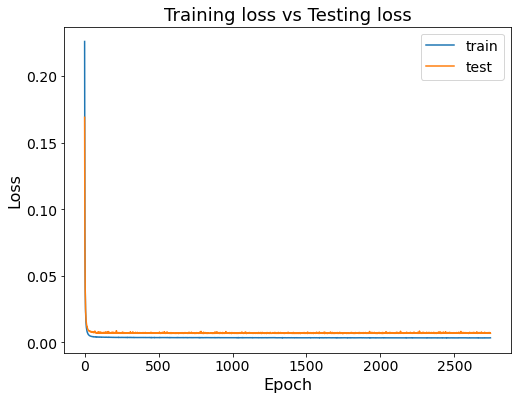

In [41]:
lr = 0.0001
EPOCHS = 6000 

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


pm25_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/pm25_cnn_sc1_4layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = pm25_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [42]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/pm25_cnn_sc1_4layer_{}h.h5'.format(K))

In [43]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (8741, 24) (8741, 24)
(8741, 24)


In [44]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 31.768
RMSE = 50.616
